In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import scipy.stats as stats
from scipy.optimize import minimize

In [48]:
analysis_results = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/event_data.csv')
parameters = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/simInput/parameters.csv')
parameters = parameters[parameters['Status'] >= 3]

In [49]:
parameters_list = parameters.columns.tolist()
[parameters_list.remove(i) for i in ['Sim','N', 'P0', 'P1', 'Status']]
print(parameters_list,'\n',len(parameters_list))

['E0', 'E1', 'CD', 'CDH', 'Threshold', 'EIonize', 'Fano', 'CoefL', 'CoefT', 'Gain', 'GETGain', 'PeakingTime', 'GasPressure'] 
 13


In [50]:
analysis_list = analysis_results.columns.tolist()
[analysis_list.remove(i) for i in ['sim','event']]
print(analysis_list,'\n',len(analysis_list))

['energy', 'trace_width', 'trace_max', 'trace_avg', 'trace_peaks', 'track_length', 'track_width', 'num_pads', 'track_peaks', 'max_pad', 'min_pad', 'avg_pad', 'event_length', 'num_peaks'] 
 14


In [51]:
combined = analysis_results.copy()
for sim in combined['sim'].unique():
    combined.loc[combined['sim'] == sim, parameters_list] = parameters.loc[parameters['Sim'] == sim, parameters_list].values

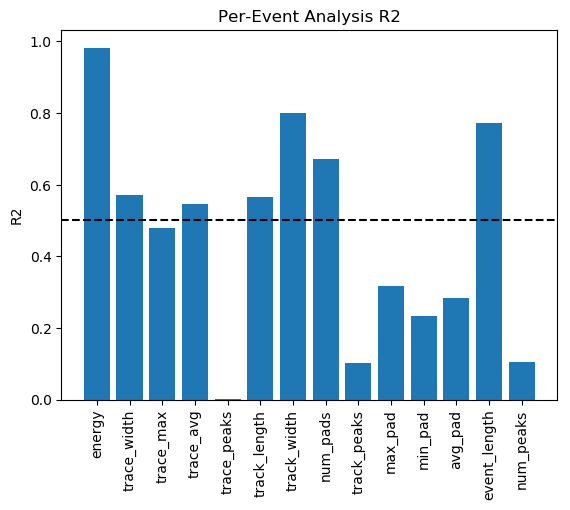

In [52]:
R2_list = []
for i, j in enumerate(analysis_list):
    X = combined[parameters_list].values
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    y = combined[j].values
    beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    y_hat = X.dot(beta)
    y_bar = np.mean(y, axis=0)
    SS_tot = np.sum((y - y_bar)**2, axis=0)
    SS_res = np.sum((y - y_hat)**2, axis=0)
    R2 = 1 - SS_res/SS_tot
    R2_list.append(R2)

plt.bar(analysis_list, R2_list)
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.axhline(y=0.5, color='k', linestyle='--')
plt.title('Per-Event Analysis R2');

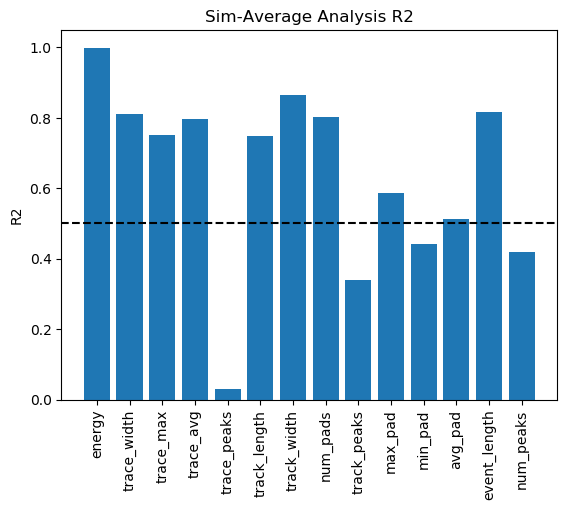

In [53]:
condensed = combined.groupby('sim').mean()
analysis_list_std = [i+'_std' for i in analysis_list]
condensed = condensed.reset_index()
condensed = condensed.dropna()
condensed = condensed.drop(columns=['event'])

R2_list = []
beta_list = []


for i, j in enumerate(analysis_list):
    X = condensed[parameters_list].values
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    y = condensed[j].values
    beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    y_hat = X.dot(beta)
    y_bar = np.mean(y, axis=0)
    SS_tot = np.sum((y - y_bar)**2, axis=0)
    SS_res = np.sum((y - y_hat)**2, axis=0)
    R2 = 1 - SS_res/SS_tot
    R2_list.append(R2)
    beta_list.append(beta)

plt.bar(analysis_list, R2_list)
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.axhline(y=0.5, color='k', linestyle='--')
plt.title('Sim-Average Analysis R2');

In [54]:
# Read in Real Data to tune against
target_analysis = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/800p.csv')
#target_analysis = target_analysis.drop(columns=[i for i in target_analysis.columns if i.endswith('_std')])
target_analysis = target_analysis.drop(columns=['sim', 'N'])
target_analysis = target_analysis.iloc[0]
# reorder columns to match
# Which attributes are within the range of the target data? 
weights = np.zeros(len(analysis_list))
for i, j in enumerate(analysis_list):
    mean_val = float(target_analysis[j])
    std_val = float(target_analysis[j+'_std'])
    weights[i] = mean_val / std_val# * float(R2_list[i])

target_analysis = target_analysis[analysis_list].values

In [55]:
weights

array([22.25331744,  5.73587918,  6.6927366 ,  5.85672681, 16.72339813,
        7.71545496,  6.58040438,  4.32339089,  2.47747786,  3.18834794,
        2.61925707,  4.18944972, 10.25545242,  2.47820875])

In [56]:
# determine optimal parameters set X such that X.dot(beta) = target_analysis
initial_guess = [800, 0.001, 1, 1, 100,22.4, 0.24, 0.000114, 0.00284, 8000, 120, 1014, 800] # initial parameters guess
X = np.array(initial_guess)

# define objective function
def objective(X, beta_list = beta_list, weights=weights, target_analysis=target_analysis):
    X = np.hstack([[1], X])
    y_hat = np.array([X.dot(beta) for beta in beta_list])
    target_analysis = np.array(target_analysis).astype(float)
    y_hat = np.array(y_hat).astype(float)
    scores = (y_hat - target_analysis)**2 * weights.astype(float)
    return np.sum(scores)

# define constraints
bounds = [(np.min(combined[i]), np.max(combined[i])) for i in parameters_list]
    

# minimize objective function
res = minimize(objective, X, bounds=bounds, method='SLSQP',
               options={'maxiter': 10000})

print('\nTuning Results:')
print('Success:',res['success'])
[print(parameters_list[i],res.x[i]) for i in range(len(parameters_list))];

print('\nPredicted Score Improvement:')
print('Init:', objective(initial_guess))
print('Final:',objective(res.x))


Tuning Results:
Success: False
E0 808.1565438226071
E1 0.001
CD 1.3315021779203735
CDH 1.0135319679750425
Threshold 109.23034680845504
EIonize 25.497028484637475
Fano 0.23448394420584462
CoefL 0.00011624991567541465
CoefT 0.0030485980260629188
Gain 7999.908471817567
GETGain 131.0266355279145
PeakingTime 1017.275454631646
GasPressure 798.752157959445

Predicted Score Improvement:
Init: 3936.8913324090886
Final: 994.9951462145484


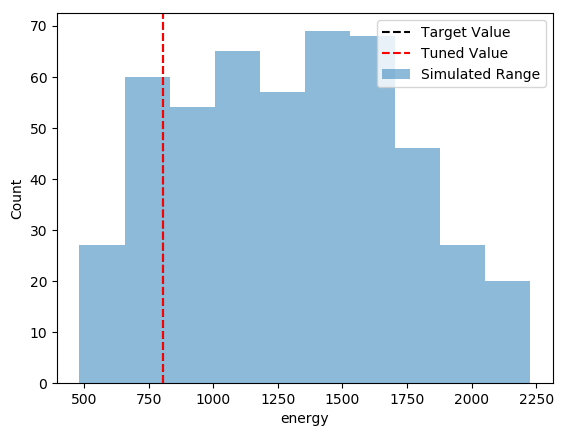

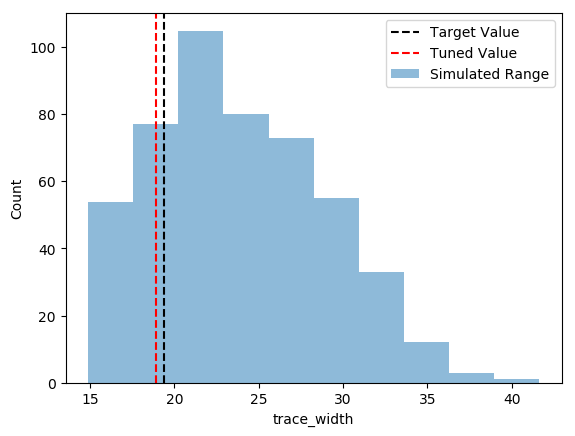

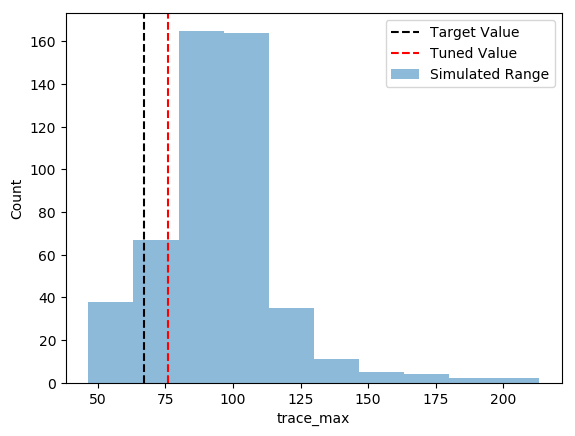

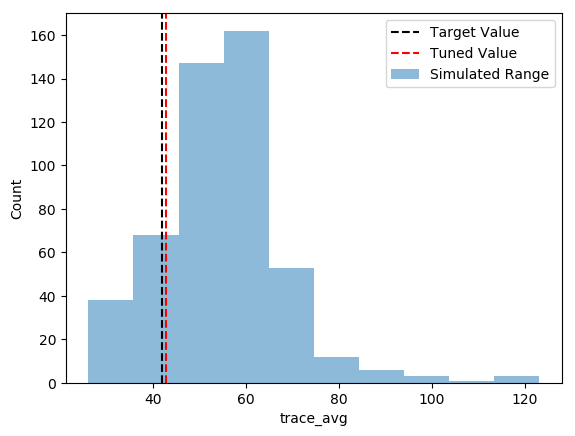

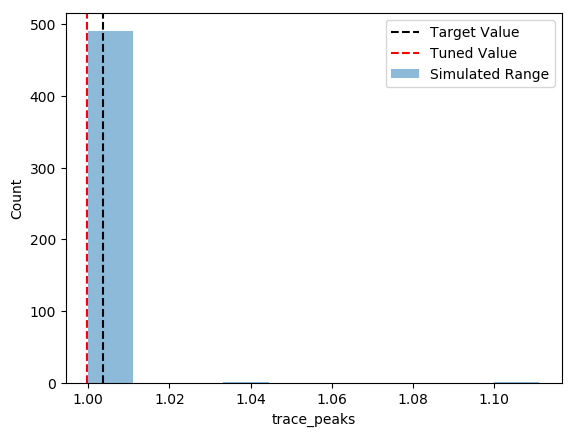

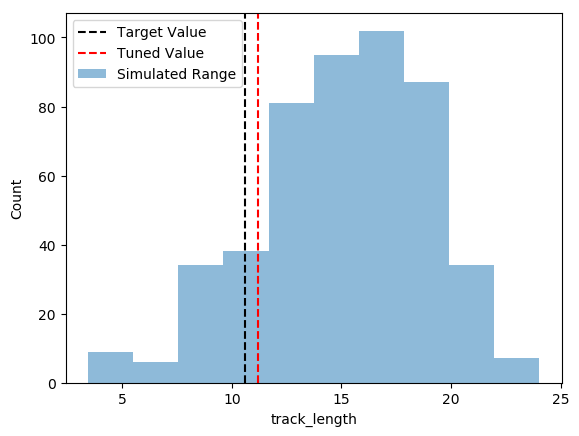

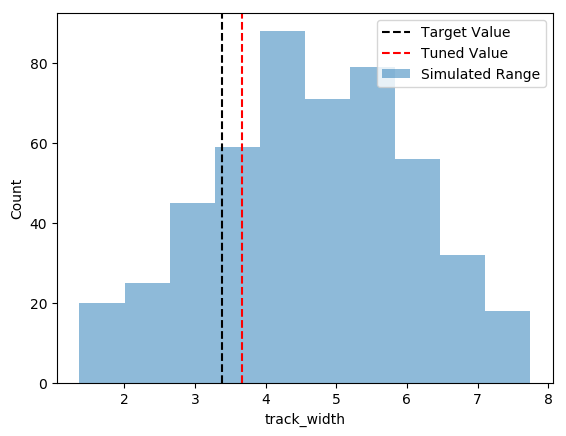

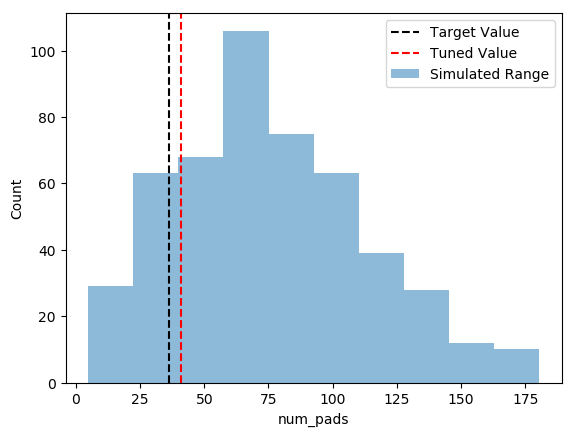

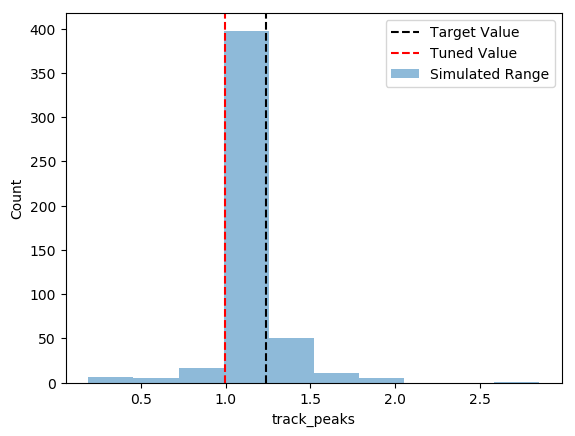

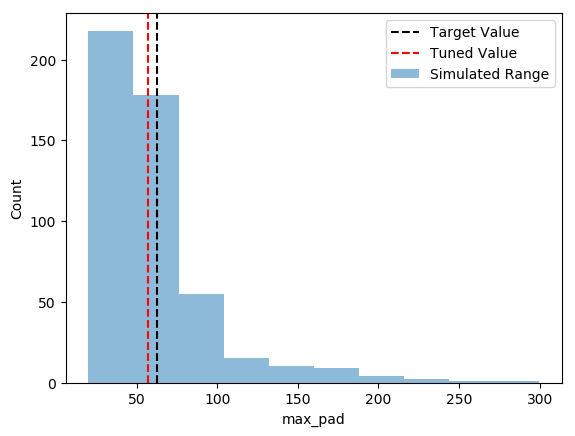

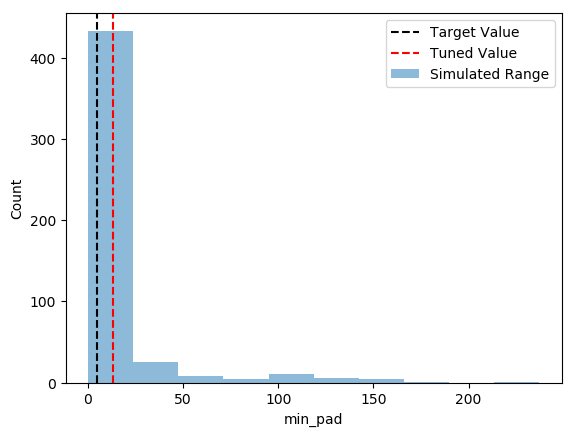

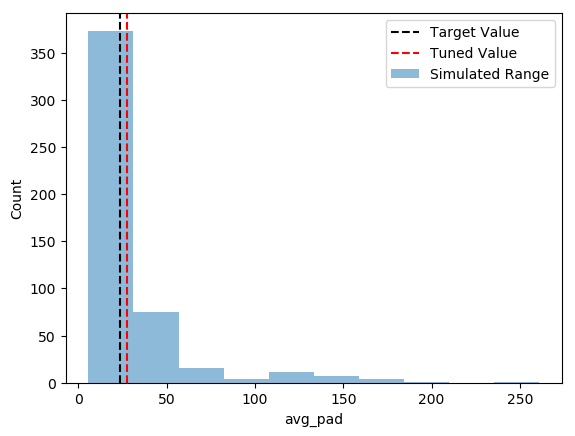

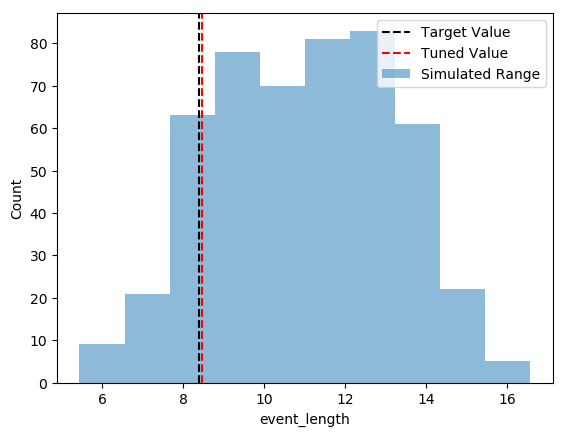

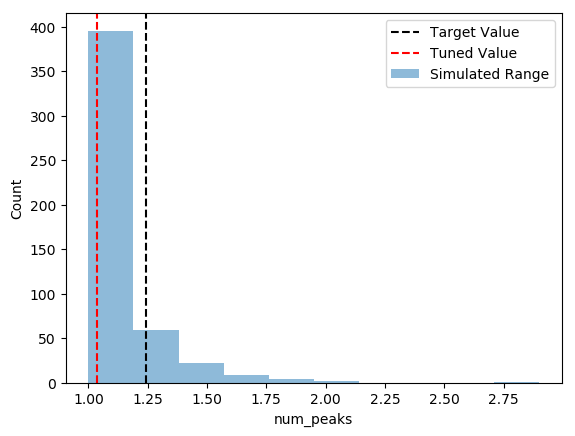

In [57]:
for i,j in enumerate(analysis_list):
    plt.hist(condensed[j], alpha=0.5, label='Simulated Range')
    plt.axvline(x=target_analysis[i], color='k', linestyle='--', label='Target Value')
    
    tuned = np.hstack([[1], res.x]).dot(beta_list[i]) # tuned value
    plt.axvline(x=tuned, color='r', linestyle='--', label='Tuned Value')
    
    plt.xlabel(j)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [58]:
# MEASURE SCORES FROM REAL SIMULATIONS
sim_data = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/sim_data.csv')
target_data = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/800p.csv')
sim_data['Score'] = sim_data[analysis_list].apply(lambda x: np.sum((x - target_data[analysis_list].values.flatten())**2 * weights), axis=1)

sim_data = sim_data.sort_values(by='Score', ascending=True)
sim_data.head()

,sim,N,energy,energy_std,trace_width,trace_width_std,trace_max,trace_max_std,trace_avg,trace_avg_std,...,max_pad_std,min_pad,min_pad_std,avg_pad,avg_pad_std,event_length,event_length_std,num_peaks,num_peaks_std,Score
293,TuneTest1,94,799.19500,2.273737e-13,21.627660,1.020889,65.502021,2.445307,36.565479,1.690739,...,12.191305,5.738181,1.857510,22.836564,4.967065,8.861213,0.248855,1.0,0.0,1116.377131
292,TuneTest0,88,799.19500,2.273737e-13,18.875000,1.156135,74.202227,3.949839,41.945693,2.508359,...,11.372949,5.148307,1.583014,20.962409,4.019865,8.155182,0.231518,1.0,0.0,1421.899808
280,VarSimCD188,182,799.19500,1.136868e-13,22.703297,0.977713,62.053813,1.954867,34.811077,1.438912,...,25.970282,4.279604,12.921922,18.682868,17.488372,9.582648,0.320171,1.0,0.0,2322.286382
439,VarSimCDA146,89,799.19500,1.136868e-13,20.640449,1.144083,67.781618,2.601673,38.312461,2.063643,...,8.782848,11.432191,6.484687,20.395202,7.450646,8.602034,0.310260,1.0,0.0,3853.321359
211,VarSimCD118,176,812.58775,3.543389e+01,21.193182,1.031966,67.515307,3.668694,37.920852,2.216246,...,10.602828,1.313693,0.353535,14.210727,2.294265,9.391239,0.220784,1.0,0.0,4586.190927
